### Подгружаем датасет и нормализуем

In [42]:
import numpy as np
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values
X = (X - X.mean())/X.std()

### Делим данные на трейнд, валидацию и тест 

In [43]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

del X_temp, y_temp, X, y

In [ ]:
# Своя сигмоида
def sigma(z):
    return 1. / (1 + np.exp(-z))

# ohe для target, т.к. так будет удобнее считать метрики
def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
    return ary

def my_SoftMax(z):
    exp_z = np.exp(z)
    return exp_z/np.sum(exp_z, axis=1)



class NeuralNetMLP:
    # Инициализируем все веса
    def __init__(self, n_features, n_hidden, n_classes, random_seed=123, learning_rate=0.1):
        self.learning_rate = learning_rate
        self.rng = np.random.RandomState(random_seed)
        self.n_features = n_features
        self.n_cl = n_classes
        self.n_hidden = n_hidden
        self.weights_h = self.rng.normal(loc=0.0, scale =0.1, size=(self.n_hidden, self.n_features))
        self.bias_h = np.zeros(self.n_hidden)
        self.weights_out = self.rng.normal(loc = 0.0, scale=0.1, size=(self.n_cl, self.n_hidden))
        self.bias_out = np.zeros(self.n_cl)

    # Проходимся по сети 'вперед' -  считаем инверенс для x
    def forward(self, x):
        z_h = np.dot(x, self.weights_h.T) + self.bias_h
        a_h = sigma(z_h)
        z_out = np.dot(a_h, self.weights_out.T) + self.bias_out
        a_out = sigma(z_out)
        return a_h, a_out

    # Проходимся по сети 'назад' - считает градиенты для всех весов
    def backward(self, x, a_h, a_out, y):
        y = int_to_onehot(y, self.n_cl)

        #out_layer
        d_L_d_a_out = -2. * (y - a_out)/y.shape[0]
        d_a_out_d_z_out = a_out * (1. - a_out)
        d_l_d_z_out = d_L_d_a_out * d_a_out_d_z_out
        d_L_d_w_out = np.dot((d_l_d_z_out).T, a_h)
        d_L_d_b_out = np.sum(d_l_d_z_out, axis=0)

        #hidden_layer
        d_z_out_d_a_h = self.weights_out
        d_a_h_d_z_h = a_h * (1. - a_h)
        d_l_d_a_h = np.dot((d_l_d_z_out), d_z_out_d_a_h)
        d_L_d_w_h = np.dot((d_l_d_a_h * d_a_h_d_z_h).T, x)
        d_L_d_b_h = np.sum(d_l_d_a_h * d_a_h_d_z_h, axis=0)
        return (d_L_d_w_out, d_L_d_b_out, d_L_d_w_h, d_L_d_b_h)

    # Реализация SGD: для x считаем градиенты и обновляем веса
    def partial_fit(self, x, y):
        a_h, a_out = self.forward(x)
        d_L_d_w_out, d_L_d_b_out, d_L_d_w_h, d_L_d_b_h = self.backward(x, a_h, a_out, y)
        self.weights_h -= self.learning_rate * d_L_d_w_h
        self.bias_h -= self.learning_rate * d_L_d_b_h
        self.weights_out -= self.learning_rate * d_L_d_w_out
        self.bias_out -= self.learning_rate * d_L_d_b_out
        return self

    # Генератор по мини-батчам
    def _mini_batch_generator(self, X, Y, size_batch):
        idx = np.arange(X.shape[0])
        np.random.shuffle(idx)
        for i in range(0, idx.shape[0] - size_batch + 1, size_batch):
            idxi = idx[i:i + size_batch]
            yield X[idxi], Y[idxi]

    # Совмещаю генератор и SGD: учусь n эпох по мини-батчам размера size_batch
    def minibatch_fit(self, X, Y, n_epoch, size_batch = 32):
        for _ in range(n_epoch):
            minibatch_gen = self._mini_batch_generator(X, Y, size_batch)
            for x, y in minibatch_gen:
                self.partial_fit(x, y)
        return self

In [36]:
model = NeuralNetMLP(n_features=28*28,
                     n_hidden=50,
                     n_classes=10)

In [37]:
def mse_loss(targets, infl, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - infl)**2)

def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)

_, infl = model.forward(X_valid)
mse = mse_loss(y_valid, infl)

predicted_labels = np.argmax(infl, axis=1)
acc = accuracy(y_valid, predicted_labels)

In [6]:
print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.3
Initial validation accuracy: 9.4%


In [7]:
model.minibatch_fit(X_train, y_train, n_epoch=50, size_batch=32)

In [8]:
_, infl = model.forward(X_valid)
mse = mse_loss(y_valid, infl)

predicted_labels = np.argmax(infl, axis=1)
acc = accuracy(y_valid, predicted_labels)

In [9]:
print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.0
Initial validation accuracy: 96.2%


In [10]:
_, infl = model.forward(X_test)
mse = mse_loss(y_test, infl)

predicted_labels = np.argmax(infl, axis=1)
acc = accuracy(y_test, predicted_labels)
print(f'Initial test MSE: {mse:.1f}')
print(f'Initial test accuracy: {acc*100:.1f}%')

Initial test MSE: 0.0
Initial test accuracy: 95.9%


In [11]:
misclassified_images = X_test[y_test != predicted_labels][:25]
misclassified_labels = predicted_labels[y_test != predicted_labels][:25]
correct_labels1 = y_test[y_test != predicted_labels][:25]

In [12]:
classified_images = X_test[y_test == predicted_labels][:25]
classified_labels =  predicted_labels[y_test == predicted_labels][:25]
correct_labels2 =  predicted_labels[y_test == predicted_labels][:25]

In [13]:
import matplotlib.pyplot as plt

### Вывожу несколько примеров, которые неправильно классифицировал

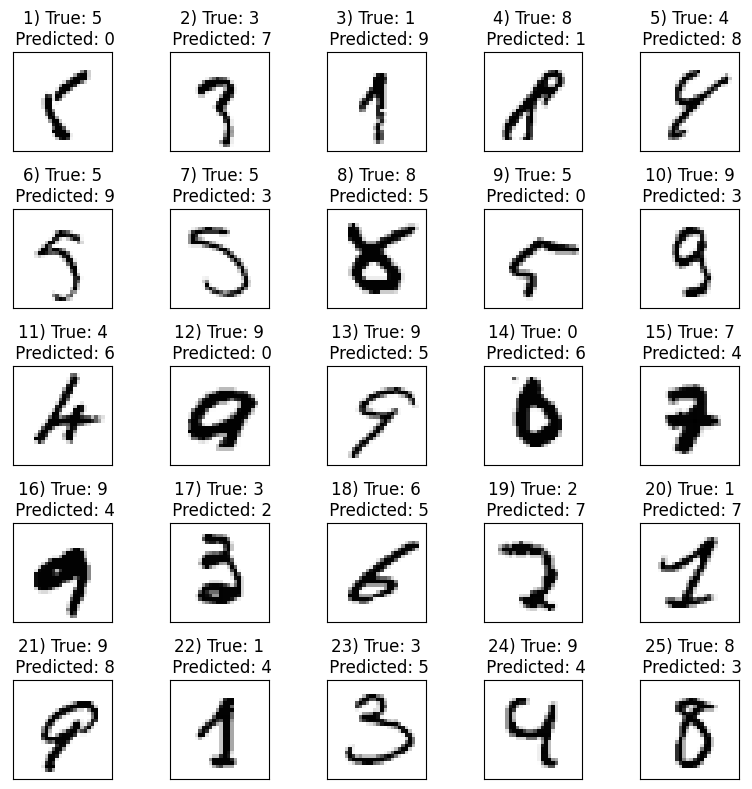

In [14]:
fig, ax = plt.subplots(nrows=5, ncols=5,
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels1[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

### А теперь те, что получились

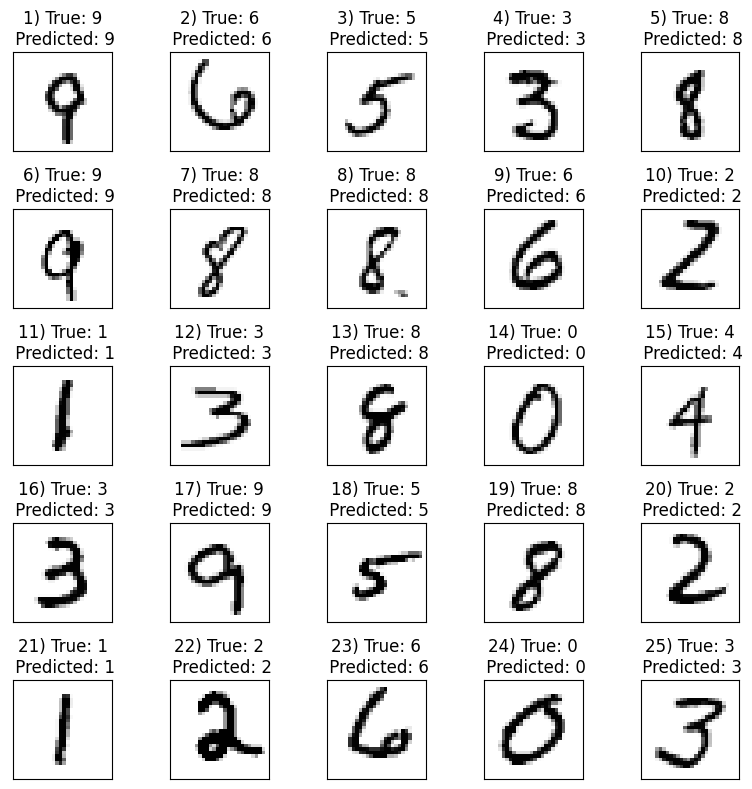

In [15]:
fig, ax = plt.subplots(nrows=5, ncols=5,
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = classified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels2[i]}\n'
                    f' Predicted: {classified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()

### А теперь подгружаю все для torch

In [16]:
import numpy as np
import torch
import torch.nn as nn
from IPython.display import Image
import torchvision
from torchvision import transforms
from torch.nn.functional import one_hot
from torch.utils.data import DataLoader, Subset

image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True,
                                           transform=transform,
                                           download=True)

mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=False,
                                           transform=transform,
                                           download=False)

batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

In [17]:
class torch_NeuralNetMLP(nn.Module):
    def __init__(self, hidden_units):
        super().__init__()
        self.hidden_units = hidden_units # количество нейронов в скрытых слоях
        image_size = mnist_train_dataset[0][0].shape
        input_size = image_size[0] * image_size[1] * image_size[2]

        all_layers = [nn.Flatten()]
        for hidden_unit in hidden_units:        # Инициализирую скрытые слои
            layer = nn.Linear(input_size, hidden_unit)
            all_layers.append(layer)
            all_layers.append(nn.ReLU())
            input_size = hidden_unit

        all_layers.append(nn.Linear(hidden_units[-1], 10)) # Выходной слой + softmax
        all_layers.append(torch.nn.Softmax(1))
        self.model = nn.Sequential(*all_layers)

    def forward(self, x):
        return self.model(x)


hidden_units = [50, 25]

torch_model = torch_NeuralNetMLP(hidden_units=hidden_units)

In [18]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

torch_model = torch_model.to(device)

### Инициализирую потери и оптимизатор: кросс-энтропия и адам 

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(torch_model.parameters(), lr=0.001)

In [20]:
def train(model, num_epochs, train_dl, valid_dl, loss_fn, optimizer):
    loss_hist_train = [0 for i in range(num_epochs)]
    accuracy_hist_train = [0 for i in range(num_epochs)]
    loss_hist_valid = [0 for i in range(num_epochs)]
    accuracy_hist_valid = [0 for i in range(num_epochs)]
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        print(f'Epoch {epoch + 1} accuracy_train: {accuracy_hist_train[epoch]} accuracy_valid: {accuracy_hist_valid[epoch]}')
    return loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid

### Обучаюсь и сохраняю результат для эпох

In [21]:
torch.manual_seed(1)
num_epochs = 50
hists = train(torch_model,
              num_epochs=num_epochs,
              train_dl=train_dl,
              valid_dl=valid_dl,
              loss_fn=loss_fn,
              optimizer=optimizer)

Epoch 1 accuracy_train: 0.8196399807929993 accuracy_valid: 0.9160000085830688
Epoch 2 accuracy_train: 0.9205999970436096 accuracy_valid: 0.9257000088691711
Epoch 3 accuracy_train: 0.9304999709129333 accuracy_valid: 0.9350000023841858
Epoch 4 accuracy_train: 0.9380800127983093 accuracy_valid: 0.9398999810218811
Epoch 5 accuracy_train: 0.9447399973869324 accuracy_valid: 0.9413999915122986
Epoch 6 accuracy_train: 0.9494600296020508 accuracy_valid: 0.9456999897956848
Epoch 7 accuracy_train: 0.9528200030326843 accuracy_valid: 0.949999988079071
Epoch 8 accuracy_train: 0.9572799801826477 accuracy_valid: 0.9509000182151794
Epoch 9 accuracy_train: 0.9600600004196167 accuracy_valid: 0.953000009059906
Epoch 10 accuracy_train: 0.9628199934959412 accuracy_valid: 0.9556000232696533
Epoch 11 accuracy_train: 0.9659600257873535 accuracy_valid: 0.9545999765396118
Epoch 12 accuracy_train: 0.9669399857521057 accuracy_valid: 0.95660001039505
Epoch 13 accuracy_train: 0.9697200059890747 accuracy_valid: 0.956

### Визуализирую accuracy для каждой эпохи. Видно, как по мере обучения метрика растет

In [22]:
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

x_arr = np.arange(len(hists[0]) + 1)
fig = make_subplots(rows=1, cols=2, subplot_titles=('Loss', 'Accuracy'))
fig.add_trace(go.Scatter(x=x_arr, y=hists[0], mode='lines+markers', name='Train loss', marker=dict(symbol='circle')), row=1, col=1)
fig.add_trace(go.Scatter(x=x_arr, y=hists[2], mode='lines+markers', name='Valid loss', marker=dict(symbol='triangle-left')), row=1, col=1)
fig.add_trace(go.Scatter(x=x_arr, y=hists[1], mode='lines+markers', name='Train accuracy', marker=dict(symbol='circle')), row=1, col=2)
fig.add_trace(go.Scatter(x=x_arr, y=hists[3], mode='lines+markers', name='Valid accuracy', marker=dict(symbol='triangle-left')), row=1, col=2)
fig.update_yaxes(title_text='Loss', row=1, col=1)
fig.update_xaxes(title_text='Epoch', row=1, col=1)
fig.update_yaxes(title_text='Accuracy', row=1, col=1)
fig.update_xaxes(title_text='Epoch', row=1, col=1)
fig.update_layout(
    title_text="Training History",
    width=800, height=400,
    legend=dict(font=dict(size=14))
)
fig.show()

### Результат на тесте

In [23]:
torch_model = torch_model.to('cpu')
pred = torch_model(mnist_test_dataset.data / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')


Test accuracy: 0.9699


### CNN

In [24]:
CNN_model = nn.Sequential()
CNN_model.add_module(
    'conv1',
    nn.Conv2d(          # o = i, o = floor((n + 2p - m) / s) + 1
        in_channels=1,
        out_channels=32,
        kernel_size=5,
        padding=2
    )
)
CNN_model.add_module(
    'ReLU1',
    nn.ReLU()
)
CNN_model.add_module(
    'Max_pool1',
    nn.MaxPool2d(kernel_size=2)     #stride=kernel_size by default => o = floor((28 -2)/2) + 1 = 14
)
CNN_model.add_module(
    'conv2',
    nn.Conv2d(
        in_channels=32,
        out_channels=64,
        kernel_size=5,
        padding=2
    )
)
CNN_model.add_module(
    'ReLU2',
    nn.ReLU()
)
CNN_model.add_module(
    'Max_pool2',
    nn.MaxPool2d(kernel_size=2)  #stride=kernel_size by default => o = floor((14 -2)/2) + 1 = 7
)
CNN_model.add_module(
    'flatten',
    nn.Flatten()
)
CNN_model.add_module(
    'Ll1',
    nn.Linear(64*7*7, 1024)
)
CNN_model.add_module(
    'ReLU3',
    nn.ReLU()
)
CNN_model.add_module(
    'dropout',
    nn.Dropout(p=0.5)
)
CNN_model.add_module(
    'Ll2',
    nn.Linear(1024, 10)
)

In [25]:
CNN_model = CNN_model.to(device)

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN_model.parameters(), lr=0.001)
hists_cnn = train(model=CNN_model,
                  num_epochs=num_epochs,
                  train_dl=train_dl,
                  valid_dl=valid_dl,
                  loss_fn=loss_fn,
                  optimizer=optimizer
                  )

Epoch 1 accuracy_train: 0.9527000188827515 accuracy_valid: 0.9817000031471252
Epoch 2 accuracy_train: 0.9846199750900269 accuracy_valid: 0.9825000166893005
Epoch 3 accuracy_train: 0.9889600276947021 accuracy_valid: 0.9868000149726868
Epoch 4 accuracy_train: 0.9920799732208252 accuracy_valid: 0.9886999726295471
Epoch 5 accuracy_train: 0.9931399822235107 accuracy_valid: 0.986299991607666
Epoch 6 accuracy_train: 0.9947999715805054 accuracy_valid: 0.9901999831199646
Epoch 7 accuracy_train: 0.9957799911499023 accuracy_valid: 0.9901999831199646
Epoch 8 accuracy_train: 0.995140016078949 accuracy_valid: 0.9890999794006348
Epoch 9 accuracy_train: 0.9965999722480774 accuracy_valid: 0.9908000230789185
Epoch 10 accuracy_train: 0.9973199963569641 accuracy_valid: 0.991100013256073
Epoch 11 accuracy_train: 0.997219979763031 accuracy_valid: 0.9918000102043152
Epoch 12 accuracy_train: 0.9972400069236755 accuracy_valid: 0.9879999756813049
Epoch 13 accuracy_train: 0.9975399971008301 accuracy_valid: 0.990

In [ ]:
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from collections import namedtuple
Parametrs = namedtuple('Parametrs', ['mode', 'name', 'marker', 'row', 'col'])
hist_parametrs = {0 : Parametrs(mode='lines+markers', name='Train loss', marker=dict(symbol='circle'), row=1, col=1),
                  1 : Parametrs(mode='lines+markers', name='Train accuracy', marker=dict(symbol='circle'), row=1, col=2),
                  2 : Parametrs(mode='lines+markers', name='Valid loss', marker=dict(symbol='triangle-left'), row=1, col=1),
                  3 : Parametrs(mode='lines+markers', name='Valid accuracy', marker=dict(symbol='triangle-left'), row=1, col=2),}
x_arr = np.arange(len(hists[0]) + 1)
fig = make_subplots(rows=1, cols=2, subplot_titles=('Loss', 'Accuracy'))
for params in range(4):
    curr_params = hist_parametrs[params]
    print(curr_params.name)
    fig.add_trace(go.Scatter(x=x_arr, y=hists_cnn[params], mode=curr_params.mode, name=curr_params.name, marker=curr_params.marker), row=curr_params.row, col=curr_params.col)
fig.update_yaxes(title_text='Loss', row=1, col=1)
fig.update_xaxes(title_text='Epoch', row=1, col=1)
fig.update_yaxes(title_text='Accuracy', row=1, col=2)
fig.update_xaxes(title_text='Epoch', row=1, col=2)
fig.update_layout(
    title_text="Training History, p = 0.5",
    width=800, height=400,
    legend=dict(font=dict(size=14))
)
fig.show()

Train loss
Train accuracy
Valid loss
Valid accuracy


In [28]:
torch.cuda.synchronize()
CNN_model_cpu = CNN_model.cpu()
pred = CNN_model_cpu(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9924


In [29]:
CNN_model = CNN_model.to(device)
CNN_model.dropout.p = 0.6
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN_model.parameters(), lr=0.001)
hists_cnn = train(model=CNN_model,
                  num_epochs=num_epochs,
                  train_dl=train_dl,
                  valid_dl=valid_dl,
                  loss_fn=loss_fn,
                  optimizer=optimizer
                  )

Epoch 1 accuracy_train: 0.998960018157959 accuracy_valid: 0.9919000267982483
Epoch 2 accuracy_train: 0.9988399744033813 accuracy_valid: 0.9927999973297119
Epoch 3 accuracy_train: 0.9991199970245361 accuracy_valid: 0.9926000237464905
Epoch 4 accuracy_train: 0.9989799857139587 accuracy_valid: 0.9922999739646912
Epoch 5 accuracy_train: 0.9990800023078918 accuracy_valid: 0.9919000267982483
Epoch 6 accuracy_train: 0.998960018157959 accuracy_valid: 0.9908000230789185
Epoch 7 accuracy_train: 0.9989799857139587 accuracy_valid: 0.9923999905586243
Epoch 8 accuracy_train: 0.9991599917411804 accuracy_valid: 0.9927999973297119
Epoch 9 accuracy_train: 0.9992799758911133 accuracy_valid: 0.9922999739646912
Epoch 10 accuracy_train: 0.9991599917411804 accuracy_valid: 0.9911999702453613
Epoch 11 accuracy_train: 0.998520016670227 accuracy_valid: 0.9933000206947327
Epoch 12 accuracy_train: 0.9990800023078918 accuracy_valid: 0.9926000237464905
Epoch 13 accuracy_train: 0.9990800023078918 accuracy_valid: 0.99

In [30]:
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

x_arr = np.arange(len(hists[0]) + 1)
fig = make_subplots(rows=1, cols=2, subplot_titles=('Loss', 'Accuracy'))
fig.add_trace(go.Scatter(x=x_arr, y=hists_cnn[0], mode='lines+markers', name='Train loss', marker=dict(symbol='circle')), row=1, col=1)
fig.add_trace(go.Scatter(x=x_arr, y=hists_cnn[2], mode='lines+markers', name='Valid loss', marker=dict(symbol='triangle-left')), row=1, col=1)
fig.add_trace(go.Scatter(x=x_arr, y=hists_cnn[1], mode='lines+markers', name='Train accuracy', marker=dict(symbol='circle')), row=1, col=2)
fig.add_trace(go.Scatter(x=x_arr, y=hists_cnn[3], mode='lines+markers', name='Valid accuracy', marker=dict(symbol='triangle-left')), row=1, col=2)
fig.update_yaxes(title_text='Loss', row=1, col=1)
fig.update_xaxes(title_text='Epoch', row=1, col=1)
fig.update_yaxes(title_text='Accuracy', row=1, col=2)
fig.update_xaxes(title_text='Epoch', row=1, col=2)
fig.update_layout(
    title_text="Training History, p = 0.6",
    width=800, height=400,
    legend=dict(font=dict(size=14))
)
fig.show()

In [31]:
torch.cuda.synchronize()
CNN_model_cpu = CNN_model.cpu()
pred = CNN_model_cpu(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9935


In [32]:
CNN_model = CNN_model.to(device)
CNN_model.dropout.p = 0.85
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN_model.parameters(), lr=0.001)
hists_cnn = train(model=CNN_model,
                  num_epochs=num_epochs,
                  train_dl=train_dl,
                  valid_dl=valid_dl,
                  loss_fn=loss_fn,
                  optimizer=optimizer
                  )

Epoch 1 accuracy_train: 0.9950799942016602 accuracy_valid: 0.9926000237464905
Epoch 2 accuracy_train: 0.9963600039482117 accuracy_valid: 0.9919999837875366
Epoch 3 accuracy_train: 0.9970399737358093 accuracy_valid: 0.9929999709129333
Epoch 4 accuracy_train: 0.9969000220298767 accuracy_valid: 0.9925000071525574
Epoch 5 accuracy_train: 0.997439980506897 accuracy_valid: 0.9929999709129333
Epoch 6 accuracy_train: 0.996999979019165 accuracy_valid: 0.9922999739646912
Epoch 7 accuracy_train: 0.9969199895858765 accuracy_valid: 0.9923999905586243
Epoch 8 accuracy_train: 0.9972599744796753 accuracy_valid: 0.9927999973297119
Epoch 9 accuracy_train: 0.9976400136947632 accuracy_valid: 0.9929999709129333
Epoch 10 accuracy_train: 0.9974200129508972 accuracy_valid: 0.9933000206947327
Epoch 11 accuracy_train: 0.9975600242614746 accuracy_valid: 0.9929999709129333
Epoch 12 accuracy_train: 0.9979400038719177 accuracy_valid: 0.9922999739646912
Epoch 13 accuracy_train: 0.9977200031280518 accuracy_valid: 0.9

In [33]:
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

x_arr = np.arange(len(hists[0]) + 1)
fig = make_subplots(rows=1, cols=2, subplot_titles=('Loss', 'Accuracy'))
fig.add_trace(go.Scatter(x=x_arr, y=hists_cnn[0], mode='lines+markers', name='Train loss', marker=dict(symbol='circle')), row=1, col=1)
fig.add_trace(go.Scatter(x=x_arr, y=hists_cnn[2], mode='lines+markers', name='Valid loss', marker=dict(symbol='triangle-left')), row=1, col=1)
fig.add_trace(go.Scatter(x=x_arr, y=hists_cnn[1], mode='lines+markers', name='Train accuracy', marker=dict(symbol='circle')), row=1, col=2)
fig.add_trace(go.Scatter(x=x_arr, y=hists_cnn[3], mode='lines+markers', name='Valid accuracy', marker=dict(symbol='triangle-left')), row=1, col=2)
fig.update_yaxes(title_text='Loss', row=1, col=1)
fig.update_xaxes(title_text='Epoch', row=1, col=1)
fig.update_yaxes(title_text='Accuracy', row=1, col=2)
fig.update_xaxes(title_text='Epoch', row=1, col=2)
fig.update_layout(
    title_text="Training History, p = 0.85",
    width=800, height=400,
    legend=dict(font=dict(size=14))
)
fig.show()

In [34]:
torch.cuda.synchronize()
CNN_model_cpu = CNN_model.cpu()
pred = CNN_model_cpu(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9941
